# Visual Transformer with Linformer

Training Visual Transformer on *Liveness Data*

* Problem - https://challenge.zalo.ai/portal/liveness-detection
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.0


In [4]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Datasets

In [7]:
import torchvision
from torchvision.transforms import ToTensor

train_data = torchvision.datasets.ImageFolder('/kaggle/input/vit-final/vit_final/train', transform=ToTensor())
valid_data = torchvision.datasets.ImageFolder('/kaggle/input/vit-final/vit_final/val', transform=ToTensor())
test_data = torchvision.datasets.ImageFolder('/kaggle/input/vit-final/vit_final/test', transform=ToTensor())

In [8]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [9]:
print(len(train_data), len(train_loader))

71198 1113


In [10]:
print(len(valid_data), len(valid_loader))

9003 141


Count number object in each class

In [11]:
from collections import Counter
Counter(train_data.targets)

Counter({0: 35016, 1: 36182})

# Plot same sample

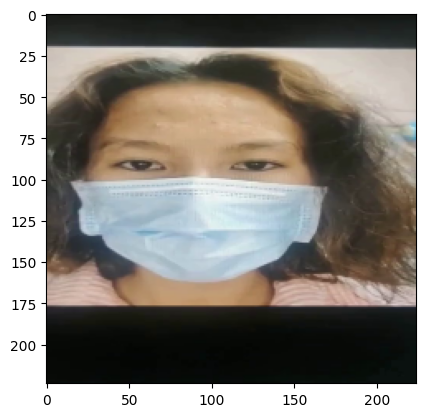

In [12]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

path_img = "/kaggle/input/vit-final/vit_final/train/fake/36183.png"
img = cv2.imread(path_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.show()

## Efficient Attention

### Linformer

In [13]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [14]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [15]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [16]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2491 - acc: 0.8893 - val_loss : 0.7543 - val_acc: 0.7664



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0441 - acc: 0.9849 - val_loss : 1.0361 - val_acc: 0.7580



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0211 - acc: 0.9928 - val_loss : 1.1840 - val_acc: 0.7636



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0134 - acc: 0.9955 - val_loss : 1.2942 - val_acc: 0.7727



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0101 - acc: 0.9962 - val_loss : 1.3684 - val_acc: 0.7730



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0083 - acc: 0.9968 - val_loss : 1.2057 - val_acc: 0.7753



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0067 - acc: 0.9974 - val_loss : 1.4244 - val_acc: 0.7704



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0045 - acc: 0.9983 - val_loss : 1.5729 - val_acc: 0.7597



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0046 - acc: 0.9982 - val_loss : 1.6473 - val_acc: 0.7597



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0041 - acc: 0.9986 - val_loss : 1.6108 - val_acc: 0.7634



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0032 - acc: 0.9988 - val_loss : 1.7792 - val_acc: 0.7630



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0032 - acc: 0.9989 - val_loss : 1.5438 - val_acc: 0.7777



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0031 - acc: 0.9989 - val_loss : 1.8708 - val_acc: 0.7527



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0029 - acc: 0.9991 - val_loss : 1.3442 - val_acc: 0.7684



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0020 - acc: 0.9994 - val_loss : 1.6403 - val_acc: 0.7650



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0022 - acc: 0.9993 - val_loss : 1.8419 - val_acc: 0.7686



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0017 - acc: 0.9994 - val_loss : 1.6197 - val_acc: 0.7685



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0020 - acc: 0.9993 - val_loss : 1.7740 - val_acc: 0.7722



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0016 - acc: 0.9995 - val_loss : 1.6487 - val_acc: 0.7695



  0%|          | 0/1113 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0017 - acc: 0.9995 - val_loss : 1.8805 - val_acc: 0.7711



# Save model

In [17]:
torch.save(model, 'model_linformer.pt')

In [18]:
MODEL_PATH = '/kaggle/input/weight-vit/model_linformer.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

# Test model

In [19]:
from tqdm import tqdm

In [20]:
epoch_test_accuracy = 0
epoch_test_loss = 0

y = []
y_predict = []

for data, label in tqdm(test_loader):
    data = data.to(device)
    label = label.to(device)

    test_output = model(data)
    acc = (test_output.argmax(dim=1) == label).float().mean()
    epoch_test_accuracy += acc / len(test_loader)
    
    prediction = test_output.argmax(dim=1)
    prediction_cpu = prediction.cpu()
    target_cpu = label.cpu()
    
  
    y = np.append(y, target_cpu.numpy())
    y_predict = np.append(y_predict,prediction_cpu.numpy())
#     print("y: ", y, "y_predict: ", y_predict)
print("Accuracy: ", epoch_test_accuracy)

100%|██████████| 129/129 [01:31<00:00,  1.41it/s]

Accuracy:  tensor(0.8621, device='cuda:0')


# Evaluate model

Plot confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y,y_predict)
print(confusion_mtx)

[[3680  537]
 [ 601 3432]]


In [22]:
"""
    This code is taken from scikit-learn website:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

"""


import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Caculate ACC, F1 Score

Confusion matrix, without normalization
[[3680  537]
 [ 601 3432]]


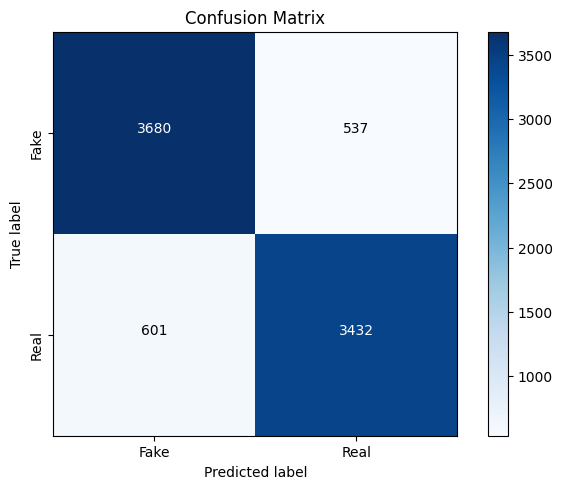

In [23]:
categories = ['Fake', 'Real']
plot_confusion_matrix(confusion_mtx, classes=categories,
                                title='Confusion Matrix')

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_predict)

0.8620606060606061

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y, y_predict, target_names=categories))

              precision    recall  f1-score   support

        Fake       0.86      0.87      0.87      4217
        Real       0.86      0.85      0.86      4033

    accuracy                           0.86      8250
   macro avg       0.86      0.86      0.86      8250
weighted avg       0.86      0.86      0.86      8250



Test on a image


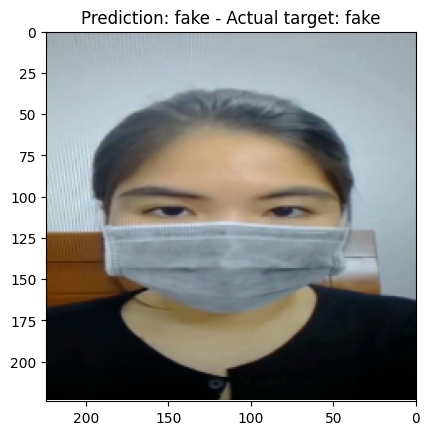

In [26]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1

eval_loader = DataLoader(dataset = test_data, batch_size=EVAL_BATCH, shuffle=True)
# Disable grad
with torch.no_grad():
    
  data, label = next(iter(eval_loader))
  originalInput = data[0].permute(1, 2, 0)
  data = data.to(device)
  label = label.to(device)

  test_output = model(data)

  prediction = test_output.argmax(dim=1)
  value_predicted = list(test_data.class_to_idx.keys())[list(test_data.class_to_idx.values()).index(prediction)]
  value_target = list(test_data.class_to_idx.keys())[list(test_data.class_to_idx.values()).index(label)]
  # Show test_data
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()